In [1]:
#using Revise
using DrWatson
@quickactivate "ABoxWorld"
include(srcdir("ABoxWorld.jl"));

┌ Info: ABoxWorld project environment is loaded and active
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\src\ABoxWorld.jl:10


In [2]:

using LinearAlgebra
using TensorOperations
using Parameters
using CairoMakie
CairoMakie.activate!()
#using GLMakie
#GLMakie.activate!()

using ProgressMeter

In [3]:

convert_matrixbox_to_nsjoint = wirings.convert_matrixbox_to_nsjoint
convert_nsjoint_to_matrixbox = wirings.convert_nsjoint_to_matrixbox


# Boxes as 2x2x2x2 tensors
MaxMixedBox = nsboxes.reconstructFullJoint(UniformRandomBox((2, 2, 2, 2)))
PR(μ, ν, σ) = nsboxes.reconstructFullJoint(PRBoxesCHSH(;μ=μ, ν=ν, σ=σ))
CanonicalPR = PR(0, 0, 0)
PL(α, γ, β, λ) = nsboxes.reconstructFullJoint(LocalDeterministicBoxesCHSH(;α=α, γ=γ, β=β, λ=λ))
SR = (PL(0,0,0,0) .+ PL(0,1,0,1)) ./ 2
#SR = matrix_to_tensor(non_local_boxes.utils.SR)
#PRprime = matrix_to_tensor(non_local_boxes.utils.PRprime)
#P0 = matrix_to_tensor(non_local_boxes.utils.P_0)
#P1 = matrix_to_tensor(non_local_boxes.utils.P_1)


CHSH_score = games.canonical_CHSH_score
#CHSHprime_score = games.CHSH_score_generator(-1,1,1,1; batched=false)
CHSHprime_score = games.CHSH_score_generator(1,-1,1,1; batched=false)


BoxProduct = wirings.tensorized_boxproduct
reduc_BoxProduct = wirings.reduc_tensorized_boxproduct
BoxProduct_matrices(w::Matrix{<:Real}, matrixbox1::Matrix{Float64}, matrixbox2::Matrix{Float64}) = convert_nsjoint_to_matrixbox(reduc_BoxProduct(w, matrixbox1, matrixbox2))


IC_Bound = Original_IC_Bound()
IC_Bound_LHS(P::Array{Float64, 4}) = conditions.evaluate(IC_Bound, P)
IC_Bound_LHS(W::Matrix{<:Real}, P_mat::Matrix{Float64}, Q_mat::Matrix{Float64}) = games.Original_IC_Bound_score(W, P_mat, Q_mat)
IC_Bound_LHS(W::Vector{<:Real}, P_mat::Matrix{Float64}, Q_mat::Matrix{Float64}) = games.Original_IC_Bound_score(W, P_mat, Q_mat)

IC_MutInfo = games.MutInfo_IC_vanDam_score



MutInfo_IC_vanDam_score (generic function with 5 methods)

In [4]:

function Compute_Coeff(P1::Array{Float64,4}, P2::Array{Float64,4}, P3::Array{Float64,4}, alt_G_score_val::Real, CHSH_score_val::Real, alt_Game_score::Function) # P1, P2, P3 are 2x2x2x2 tensors
    A = [alt_Game_score(P1) alt_Game_score(P2) alt_Game_score(P3);
           CHSH_score(P1)     CHSH_score(P2)     CHSH_score(P3);
                1                    1                1           ]
    b = [alt_G_score_val, CHSH_score_val, 1]
    return A \ b # Equiv. to np.linalg.solve(A, b)
end


function is_in_NPA_TLM(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    #return conditions.check(NPA_TLM_Criterion(), Box)

    E_xy = ProbBellCorrelator(Box)
    coeff00 = asin(E_xy[1,1])
    coeff01 = asin(E_xy[1,2])
    coeff10 = asin(E_xy[2,1])
    coeff11 = asin(E_xy[2,2])
    return coeff00 + coeff01 + coeff10 - coeff11 <= pi
end



function is_in_NPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Union{String,Int})
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_in_NPA(Box; level=level, verbose=false)    
end

function is_in_NPA(Box::Array{Float64,4}; level::Union{String,Int})
    return sdp_conditions.is_in_NPA(Box; level=level, verbose=false)    
end

function is_asymp_in_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_asymp_in_pyNPA(Box; level=level, verbose=false)
end


function is_in_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_in_pyNPA(Box; level=level, verbose=false)
end

function min_distance_to_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    p_obs = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.min_distance_to_pyNPA(p_obs; level=level, verbose=false)
end

    
function nearest_pyNPA_point(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    p_obs = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.nearest_pyNPA_point(p_obs; level=level, verbose=false)
end

is_NOT_in_IC(P::Array{Float64,4}) = !(conditions.check(Original_IC_Bound(), P, :Q))
#is_NOT_in_IC(P::Array{Float64,4}) = !(conditions.check(Generalized_Original_IC_Bound(), P, :Q))

function is_NOT_in_IC(secondary_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, secondary_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, secondary_score_val, CHSH_score_val, secondary_score)
    MixedBox = α*Box1 + β*Box2 + γ*Box3
    
    return is_NOT_in_IC(MixedBox)
    #return conditions.check(Generalized_Original_IC_Bound(), MixedBox, :Q)
end

is_NOT_in_Uffink(P::Array{Float64,4}) = !(conditions.check(Uffink_Bipartite_2222_Inequality(), P, :Q))

function is_NOT_in_Uffink(secondary_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, secondary_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, secondary_score_val, CHSH_score_val, secondary_score)
    MixedBox = α*Box1 + β*Box2 + γ*Box3
    
    return is_NOT_in_Uffink(MixedBox)
    #return conditions.check(Uffink_Bipartite_2222_Inequality(), MixedBox, :Q)
end


is_NOT_in_CorrelatedInputs_IC(P::Array{Float64,4}) = !(conditions.check(Correlated_Inputs_IC_Bound(;ϵ=0.99), P, :Q))

function is_NOT_in_CorrelatedInputs_IC(secondary_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, secondary_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, secondary_score_val, CHSH_score_val, secondary_score)
    MixedBox = α*Box1 + β*Box2 + γ*Box3
    
    return is_NOT_in_CorrelatedInputs_IC(MixedBox)
end

#is_NOT_in_RedundantIC(P::Array{Float64,4}) = !(conditions.check(Limited_RedundantInfo_IC_Bound(), P, :Q))
is_NOT_in_RedundantIC(P::Array{Float64,4}) = !(conditions.check(RedundantInfo_IC_Bound(), P, :Q))

function is_NOT_in_RedundantIC(secondary_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, secondary_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, secondary_score_val, CHSH_score_val, secondary_score)
    MixedBox = α*Box1 + β*Box2 + γ*Box3
    
    return is_NOT_in_RedundantIC(MixedBox)
end


is_NOT_in_RedundantIC (generic function with 2 methods)

In [5]:
@with_kw struct SliceBoundsPlotConfig
    Box1::Pair{String, Array{Float64,4}}
    Box2::Pair{String, Array{Float64,4}}
    Box3::Pair{String, Array{Float64,4}}
    primary_score::Function = CHSH_score
    secondary_score::Function
    IC_violation_criterion::Function = is_NOT_in_IC
    boundary_precision::Float64
    precision::Float64
end

DrWatson.default_prefix(c::SliceBoundsPlotConfig) = "SliceBoundsPlot_"*c.Box1.first*"_"*c.Box2.first*"_"*c.Box3.first*"_"*string(c.primary_score)*"_"*string(c.secondary_score)*"_boundary_precision_"*string(c.boundary_precision)
DrWatson.allaccess(::SliceBoundsPlotConfig) = tuple()


In [8]:
function Slice_Bounds_Plot(config::SliceBoundsPlotConfig; verbose::Bool=false)

    results = Dict(string(key) => getfield(config, key) for key in fieldnames(SliceBoundsPlotConfig))

    is_NOT_in_IC = config.IC_violation_criterion

    P1, P2, P3 = config.Box1.second, config.Box2.second, config.Box3.second
    secondary_score = config.secondary_score

    # Draw the initial background triangle:
    x1, y1 = secondary_score(P1), CHSH_score(P1) #Stays CHSH because it's the coordinate system of the plot, also in IC
    x2, y2 = secondary_score(P2), CHSH_score(P2)
    x3, y3 = secondary_score(P3), CHSH_score(P3)
    @show (x1, y1), (x2, y2), (x3, y3)
    ns_extremes = [(x1, y1), (x2, y2), (x3, y3)]
    results["ns_extremes"] = ns_extremes

    # Check if our coordinate system is good, i.e. if projected points aren't aligned (= allow 2D viz.):
    ( (x1 - x3)*(y2-y3)==(x2-x3)*(y1-y3) ) && error("We can't make a 2D plot from a 0D or 1D space of points.")


    # Compute the Quantum boundary:
    println("Computing Quantum boundary...")
    membership_level = 3
    c_secondary_score_val=min(x2,x3) #Initialize at x-axis origin
    c_CHSH_score_val=4 #Safely initialize at the maximum local value of CHSH
    results["quantum_secondary_scores"] = Float64[]
    results["quantum_primary_scores"] = Float64[]
    while c_secondary_score_val <= max(x2, x3)
        if is_in_NPA(c_secondary_score_val, c_CHSH_score_val, P1, P2, P3, secondary_score, membership_level) 
            push!(results["quantum_secondary_scores"], c_secondary_score_val)
            push!(results["quantum_primary_scores"], c_CHSH_score_val)
            c_secondary_score_val += config.boundary_precision
        else 
            if c_CHSH_score_val - config.boundary_precision > y2  #Still on the canvas of our viz.
                c_CHSH_score_val -= config.boundary_precision
            else
                c_CHSH_score_val=y2 #Take the canvas lower-boundary as the quantum boundary (even if it's not in the Q set) 
                c_secondary_score_val += config.boundary_precision # Go to the next point along x-axis / vertical line 
            end
        end
    end


    # Compute the AlmostQuantum boundary:
    println("Computing AlmostQuantum boundary...")
    membership_level = "1 + A B"
    c_secondary_score_val=min(x2,x3) #Initialize at x-axis origin
    c_CHSH_score_val=4 #Safely initialize at the maximum local value of CHSH
    results["AlmostQuantum_secondary_scores"] = copy(results["quantum_secondary_scores"]) #Float64[]
    results["AlmostQuantum_primary_scores"] = Union{Float64, Missing}[]
    while c_secondary_score_val <= max(x2, x3)
        if is_in_NPA(c_secondary_score_val, c_CHSH_score_val, P1, P2, P3, secondary_score, membership_level) 
            push!(results["AlmostQuantum_primary_scores"], c_CHSH_score_val)
            c_secondary_score_val += config.boundary_precision
        else 
            if c_CHSH_score_val - config.boundary_precision > y2  #Still on the canvas of our viz.
                c_CHSH_score_val -= config.boundary_precision
            else
                c_CHSH_score_val=y2 #Take the canvas lower-boundary as the quantum boundary (even if it's not in the Q set) 
                c_secondary_score_val += config.boundary_precision # Go to the next point along x-axis / vertical line 
            end
        end
    end
    
    # Compute the IC boundary:
    println("Computing IC boundary...")
    algebraic_max_CHSH_score = 4.0
    min_secondary_score = 0.0
    c_secondary_score_val = min(x2,x3) #Reset x-axis pointer to smallest value on the x-axis
    init_CHSH_guess = 2.0
    c_CHSH_score_val = init_CHSH_guess
    #In this scenario, need to ensure that Quantum and IC boundaries are aligned
    results["IC_secondary_scores"] = copy(results["quantum_secondary_scores"]) #Float64[]
    results["IC_primary_scores"] = Union{Float64, Missing}[]
    #
    @showprogress "Computing IC boundary..." for c_secondary_score_val in results["IC_secondary_scores"] 
        while c_CHSH_score_val <= algebraic_max_CHSH_score - c_secondary_score_val + min_secondary_score #Check whether still within NS region; equiv. to whether there still is a pair of (G, CHSH) that can be in the NS region

            if is_NOT_in_IC(c_secondary_score_val, c_CHSH_score_val, P1, P2, P3, secondary_score)
                push!(results["IC_primary_scores"], c_CHSH_score_val)
                c_CHSH_score_val = (algebraic_max_CHSH_score - max(x2, x3))*(c_secondary_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_secondary_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange (linear?) interpolation on plot origin (0.75, 0.75) and (0.5, init_CHSH_guess) for x-point of next iteration; Set new initial y-value to 
                break # Success, so move on to next point along x-axis
                #That's because, Above CHSH guess does not work if boundary happens to be concave! (might guess to high -> too loose boundary)
            else
                if c_CHSH_score_val + config.boundary_precision < (algebraic_max_CHSH_score-c_secondary_score_val)
                    #if c_secondary_score_val > 0.12 && c_CHSH_score_val > 3.5
                    #    @show c_CHSH_score_val
                    #end
                    c_CHSH_score_val += config.boundary_precision #Stay at same x-point, but go up along y-axis
                else 
                    #Accept that we're at the boundary of the NS region and move on to the next x-point
                    #push!(results["IC_primary_scores"], missing) #Add the NS boundary point to the list
                    push!(results["IC_primary_scores"], algebraic_max_CHSH_score - c_secondary_score_val + min_secondary_score) #Add the NS boundary point to the list
                    c_CHSH_score_val = (algebraic_max_CHSH_score - max(x2, x3))*(c_secondary_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_secondary_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange interpolation; Same as in comment above
                    break
                end
            end
        end
    end


    # Compute the CorrelatedInputs IC Boundary
    println("Computing CorrelatedInputs IC boundary...")
    algebraic_max_CHSH_score = 4.0
    min_secondary_score = 0.0
    c_secondary_score_val = min(x2,x3) #Reset x-axis pointer to smallest value on the x-axis
    init_CHSH_guess = 2.0
    c_CHSH_score_val = init_CHSH_guess
    #In this scenario, need to ensure that Quantum and IC boundaries are aligned
    results["CorrelatedInputs_IC_secondary_scores"] = copy(results["quantum_secondary_scores"]) #Float64[]
    results["CorrelatedInputs_IC_primary_scores"] = Union{Float64, Missing}[]
    #
    @showprogress "Computing CorrelatedInputs IC boundary..." for c_secondary_score_val in results["CorrelatedInputs_IC_secondary_scores"] 
        while c_CHSH_score_val <= algebraic_max_CHSH_score - c_secondary_score_val + min_secondary_score #Check whether still within NS region; equiv. to whether there still is a pair of (G, CHSH) that can be in the NS region

            if is_NOT_in_CorrelatedInputs_IC(c_secondary_score_val, c_CHSH_score_val, P1, P2, P3, secondary_score)
                push!(results["CorrelatedInputs_IC_primary_scores"], c_CHSH_score_val)
                c_CHSH_score_val = (algebraic_max_CHSH_score - max(x2, x3))*(c_secondary_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_secondary_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange (linear?) interpolation on plot origin (0.75, 0.75) and (0.5, init_CHSH_guess) for x-point of next iteration; Set new initial y-value to 
                break # Success, so move on to next point along x-axis
                #That's because, Above CHSH guess does not work if boundary happens to be concave! (might guess to high -> too loose boundary)
            else
                if c_CHSH_score_val + config.boundary_precision < (algebraic_max_CHSH_score-c_secondary_score_val)
                    #if c_secondary_score_val > 0.12 && c_CHSH_score_val > 3.5
                    #    @show c_CHSH_score_val
                    #end
                    c_CHSH_score_val += config.boundary_precision #Stay at same x-point, but go up along y-axis
                else 
                    #Accept that we're at the boundary of the NS region and move on to the next x-point
                    push!(results["CorrelatedInputs_IC_primary_scores"], algebraic_max_CHSH_score - c_secondary_score_val + min_secondary_score) #Add the NS boundary point to the list
                    c_CHSH_score_val = (algebraic_max_CHSH_score - max(x2, x3))*(c_secondary_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_secondary_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange interpolation; Same as in comment above
                    break
                end
            end
        end
    end

    
    # Compute the Redundant-IC Boundary
    println("Computing Redundant_IC boundary...")
    algebraic_max_CHSH_score = 4.0
    min_secondary_score = 0.0
    c_secondary_score_val = min(x2,x3) #Reset x-axis pointer to smallest value on the x-axis
    init_CHSH_guess = 2.0
    c_CHSH_score_val = init_CHSH_guess
    #In this scenario, need to ensure that Quantum and IC boundaries are aligned
    results["Redundant_IC_secondary_scores"] = copy(results["quantum_secondary_scores"]) #Float64[]
    results["Redundant_IC_primary_scores"] = Union{Float64, Missing}[]
    #
    @showprogress "Computing Redundant_IC boundary..." for c_secondary_score_val in results["Redundant_IC_secondary_scores"] 
        while c_CHSH_score_val <= algebraic_max_CHSH_score - c_secondary_score_val + min_secondary_score #Check whether still within NS region; equiv. to whether there still is a pair of (G, CHSH) that can be in the NS region

            if is_NOT_in_RedundantIC(c_secondary_score_val, c_CHSH_score_val, P1, P2, P3, secondary_score)
                push!(results["Redundant_IC_primary_scores"], c_CHSH_score_val)
                c_CHSH_score_val = (algebraic_max_CHSH_score - max(x2, x3))*(c_secondary_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_secondary_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange (linear?) interpolation on plot origin (0.75, 0.75) and (0.5, init_CHSH_guess) for x-point of next iteration; Set new initial y-value to 
                break # Success, so move on to next point along x-axis
                #That's because, Above CHSH guess does not work if boundary happens to be concave! (might guess to high -> too loose boundary)
            else
                if c_CHSH_score_val + config.boundary_precision < (algebraic_max_CHSH_score-c_secondary_score_val)
                    if c_secondary_score_val > 0.12 && c_CHSH_score_val > 3.5
                        @show c_CHSH_score_val
                    end
                    c_CHSH_score_val += config.boundary_precision #Stay at same x-point, but go up along y-axis
                else 
                    #Accept that we're at the boundary of the NS region and move on to the next x-point
                    push!(results["Redundant_IC_primary_scores"], algebraic_max_CHSH_score - c_secondary_score_val + min_secondary_score) #Add the NS boundary point to the list
                    c_CHSH_score_val = (algebraic_max_CHSH_score - max(x2, x3))*(c_secondary_score_val-min(x2, x3))/(max(x2, x3)-min(x2, x3)) + init_CHSH_guess*(c_secondary_score_val-max(x2, x3))/(min(x2,x3)-max(x2, x3)) # Lagrange interpolation; Same as in comment above
                    break
                end
            end
        end
    end
    


    return results
end

Slice_Bounds_Plot (generic function with 1 method)

In [28]:


CHSHprime_score = games.CHSH_score_generator(-1,1,1,1; batched=false)
#CHSHprime_score = games.CHSH_score_generator(1,-1,1,1; batched=false)


c_config = SliceBoundsPlotConfig(Box1=("PR"=>CanonicalPR),
                                Box2=("I"=>MaxMixedBox),
                                #Box3=("PL(0,0,0,0)"=>PL(0,0,0,0)),
                                #Box3=("PR(0,1,0)"=>PR(0,1,0)),
                                Box3=("PR(1,1,0)"=>PR(1,1,0)),
                                #Box3=("PL(0,1,0,1)"=>PL(0,1,0,1)),
                                primary_score=CHSH_score,
                                secondary_score=CHSHprime_score,
                                IC_violation_criterion = is_NOT_in_IC, 
                                boundary_precision=6e-3, #3e-3,
                                precision=1.4e-2,
                                )

    
data_output = Slice_Bounds_Plot(c_config; verbose=true)

#data_output, data_filename = produce_or_load(Slice_Bounds_Plot, 
#                                            c_config,
#                                            mkpath(datadir("SliceBoundsPlot"));
#                                            verbose=true,
#                                           )
                


((x1, y1), (x2, y2), (x3, y3)) = ((0.0, 4.0), (0.0, 0.0), (4.0, 0.0))
Computing Quantum boundary...
Computing AlmostQuantum boundary...
Computing IC boundary...


Computing IC boundary... 100%|███████████████████████████| Time: 0:00:02
Computing CorrelatedInputs IC boundary...   3%|█         |  ETA: 0:00:04

Computing CorrelatedInputs IC boundary...


Computing CorrelatedInputs IC boundary... 100%|██████████| Time: 0:00:03


Computing Redundant_IC boundary...


Computing Redundant_IC boundary... 100%|█████████████████| Time: 0:00:57


Dict{String, Any} with 19 entries:
  "Redundant_IC_secondary_… => [0.0, 0.006, 0.012, 0.018, 0.024, 0.03, 0.036, 0…
  "secondary_score"         => abs_CHSH_score
  "IC_secondary_scores"     => [0.0, 0.006, 0.012, 0.018, 0.024, 0.03, 0.036, 0…
  "AlmostQuantum_primary_s… => Union{Missing, Float64}[2.824, 2.824, 2.824, 2.8…
  "precision"               => 0.014
  "CorrelatedInputs_IC_pri… => Union{Missing, Float64}[3.962, 3.956, 3.953, 3.9…
  "IC_primary_scores"       => Union{Missing, Float64}[2.834, 2.834, 2.831, 2.8…
  "quantum_primary_scores"  => [2.824, 2.824, 2.824, 2.824, 2.824, 2.824, 2.824…
  "Box3"                    => "PR(1,1,0)"=>[0.5 0.0; 0.0 0.5;;; 0.0 0.5; 0.5 0…
  "IC_violation_criterion"  => is_NOT_in_IC
  "boundary_precision"      => 0.006
  "AlmostQuantum_secondary… => [0.0, 0.006, 0.012, 0.018, 0.024, 0.03, 0.036, 0…
  "primary_score"           => canonical_CHSH_score
  "Redundant_IC_primary_sc… => Union{Missing, Float64}[2.834, 2.834, 2.831, 2.8…
  "Box1"            

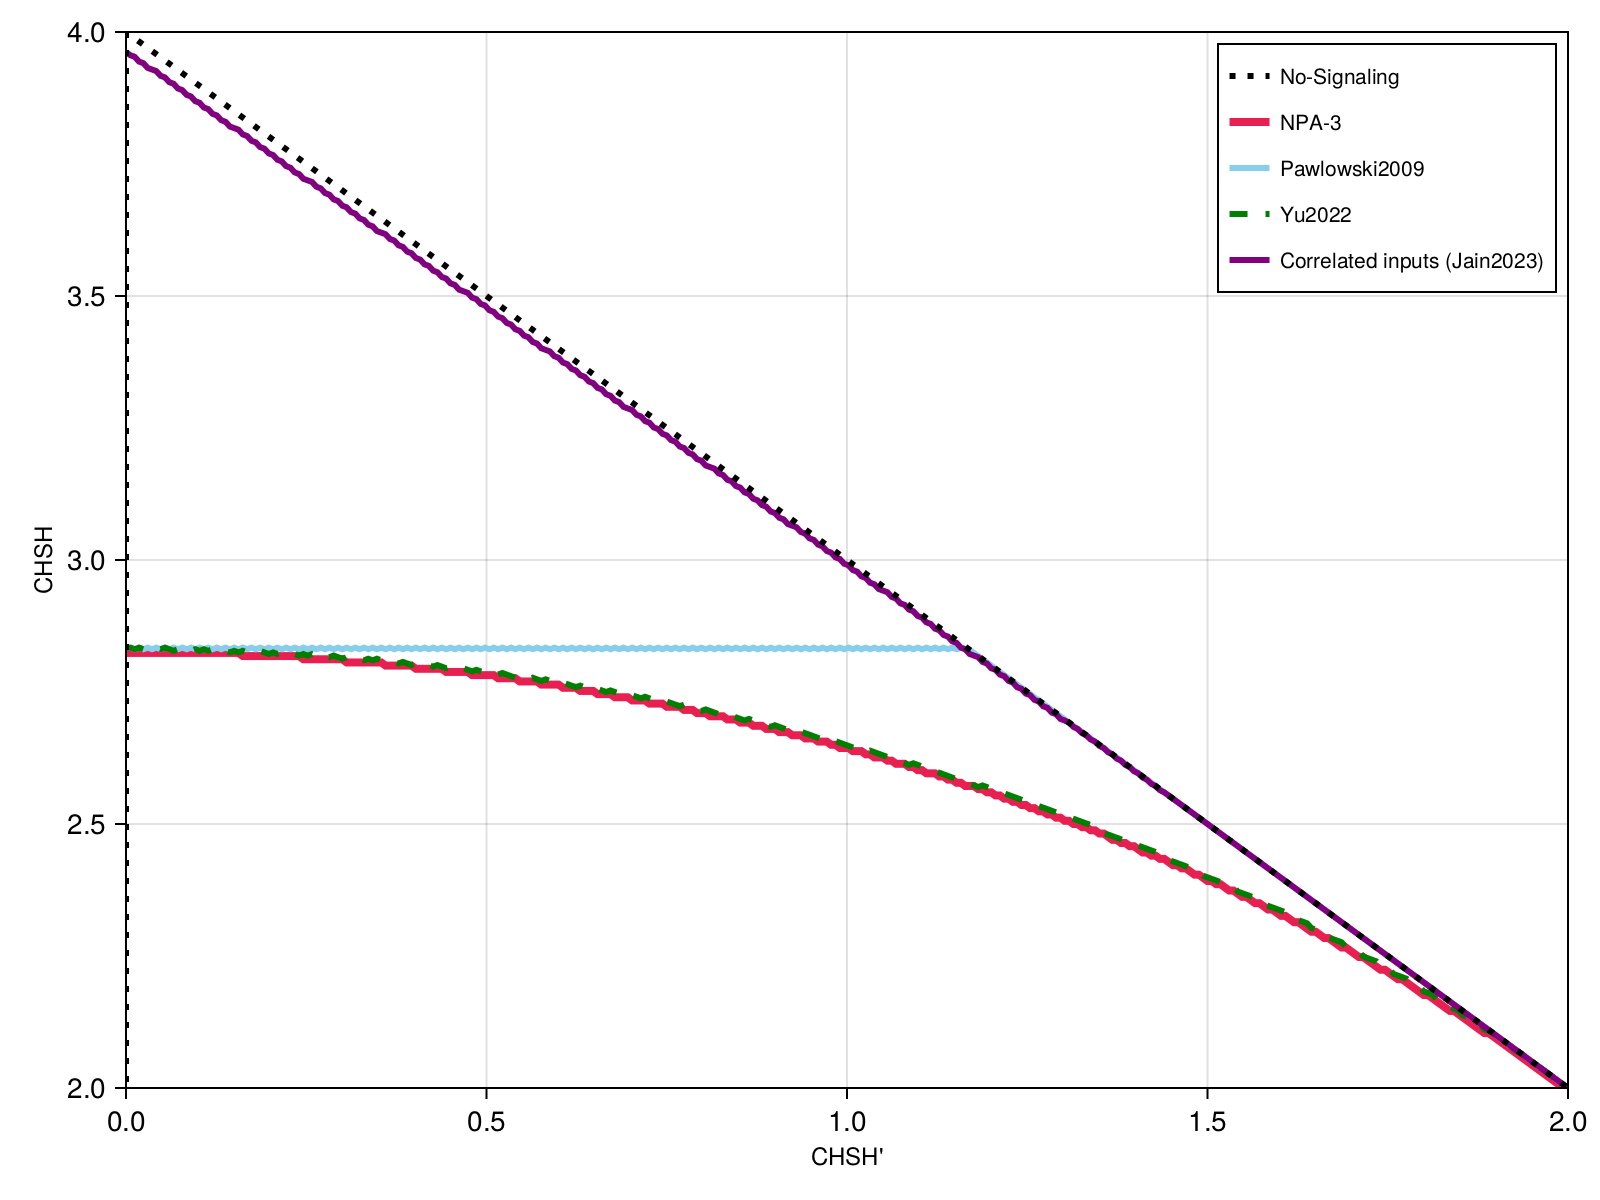

In [30]:
function plot_Slice_Bounds(data::Dict; markersize::Real=4, big::Bool=true)

    # Initialize figure and colors:
    IC_color = :skyblue
    Redundant_IC_color = :green
    NS_color = :black
    Quantum_color = "#e82051"
    CorrelatedInputs_IC_color = :purple

    fig = Figure(; size=(800,600))
    
    ax = Axis(fig[1, 1]; xlabel = "CHSH'", ylabel = "CHSH", xlabelsize=(big ? 12 : 10), ylabelsize=(big ? 12 : 10),
            #titlevisible=title_visible, titlesize=(big ? 15 : 12.5), title =L"IC Violating Boxes ($K_{{reset}}$=%$(K_reset), χ=%$(χ), m=$10^%$(Int(log10(m)))$, M=%$(LS_iterations), N=%$(max_power)).",
            )
    #xlims!(ax, min(map(first, data["ns_extremes"])...), max(map(first, data["ns_extremes"])...))
    xlims!(ax, -0, 2)
    #ylims!(ax, min(y1, y2, y3), max(y1, y2, y3))
    ylims!(ax, 2, 4)
    #ylims!(ax, 1.99, 2.1*sqrt(2))


    #Draw the Quantum boundary:
    quantum_boundary_line = lines!(ax, data["quantum_secondary_scores"], data["quantum_primary_scores"]; color=Quantum_color, linewidth=4,  linestyle=:solid)


    #Draw the unwired IC boundary:
    IC_boundary_line = lines!(ax, data["IC_secondary_scores"], data["IC_primary_scores"]; color=IC_color, linewidth=3)


    #middle_points_IC_Q = data["quantum_primary_scores"][1:end-(length(data["quantum_secondary_scores"])-length(data["IC_secondary_scores"]))] + (data["IC_primary_scores"] - data["quantum_primary_scores"][1:end-(length(data["quantum_secondary_scores"])-length(data["IC_secondary_scores"]))]) ./ 2 
    #lines!(ax, data["IC_secondary_scores"], middle_points_IC_Q; color="black", linestyle=:dash, linewidth=1.5)
    
    #Draw the Redundant IC boundary:
    Redundant_IC_boundary_line = lines!(ax, data["Redundant_IC_secondary_scores"], data["Redundant_IC_primary_scores"]; color=Redundant_IC_color, linewidth=3, linestyle=:dash)

    #Draw the Redundant IC boundary:
    CorrelatedInputs_IC_boundary_line = lines!(ax, data["CorrelatedInputs_IC_secondary_scores"], data["CorrelatedInputs_IC_primary_scores"]; color=CorrelatedInputs_IC_color, linewidth=3)

    #Draw the Boundary of the NS set:
    ns_boundary_line = lines!(ax, [map(first, data["ns_extremes"])..., data["ns_extremes"][1][1]], [map(last, data["ns_extremes"])..., data["ns_extremes"][1][end]]; color=NS_color, linewidth=3, linestyle=:dot)

    #Draw the AlmostQuantum boundary:
    #AlmostQuantum_boundary_line = lines!(ax, data["AlmostQuantum_secondary_scores"], data["AlmostQuantum_primary_scores"]; color=:orange, linewidth=3, linestyle=:dash)
    #Misc. plot settings:
        
    legend_visible = true
    legend_visible ? (axislegend(ax, [ns_boundary_line, quantum_boundary_line, IC_boundary_line, Redundant_IC_boundary_line, CorrelatedInputs_IC_boundary_line],
                                ["No-Signaling","NPA-3", "Pawlowski2009", "Yu2022", "Correlated inputs (Jain2023)"];
                                position = :rt, labelsize = (big ? 10.5 : 9.5) )) : nothing
    #save(plotsdir("fex.png"), fig)
    fig # equiv. to plt.show()
end

plot_Slice_Bounds(data_output ;markersize=10,)

#### JainSlicePlot

In [17]:
function double_noisy_PRBox(;q1, q2)
    @assert 0.0 - 10*eps() <= q1 <= 1.0 + 10*eps() 
    @assert 0.0 - 10*eps() <= q2 <= 1.0 + 10*eps()
    #@show q1, q2, 1.0-q1-q2
    @assert q1 + q2 <= 1.0 + 100*eps()
    nsbox = (1.0-q1-q2)*CanonicalPRBox() + q1*LocalDeterministicBoxesCHSH(α=1, γ=0, β=0, λ=0) + q2*LocalDeterministicBoxesCHSH(α=1, γ=0, β=1, λ=0)
    #return c2*extremal_noise_generator(;extremal_noise_params...) + (1-c1-c2)*UniformRandomBox(scenario)
    return nsboxes.reconstructFullJoint(nsbox)
end

conditions.evaluate(Original_IC_Bound(), double_noisy_PRBox(q1=0.3, q2=0.05))

4.929999999999999

In [18]:
@with_kw struct JainSliceBoundsPlotConfig
    boundary_precision::Float64
    precision::Float64
end

DrWatson.default_prefix(c::JainSliceBoundsPlotConfig) = "JainSliceBoundsPlot_"*"boundary_precision_"*string(c.boundary_precision)
DrWatson.allaccess(::JainSliceBoundsPlotConfig) = tuple()

In [19]:
function Jain_Slice_Bounds_Plot(config::JainSliceBoundsPlotConfig; verbose::Bool=false)
    results = Dict{String, Any}(string(key) => getfield(config, key) for key in fieldnames(JainSliceBoundsPlotConfig))

    P1, P2, P3 = LocalDeterministicBoxesCHSH(α=1, γ=0, β=0, λ=0), CanonicalPR, LocalDeterministicBoxesCHSH(α=1, γ=0, β=1, λ=0)

    # Draw the initial background triangle:
    q1_1, q2_1 = 1.0, 0.0
    q1_2, q2_2 = 0.0, 0.0
    q1_3, q2_3 = 0.0, 1.0
    ns_extremes = [(q1_1, q2_1), (q1_2, q2_2), (q1_3, q2_3)]
    results["ns_extremes"] = ns_extremes

    q2_stepsize = config.boundary_precision

    # Compute the Quantum boundary:
    println("Computing Quantum boundary...")
    membership_level = 3

    results["quantum_q1_vals"] = collect(0.0:config.boundary_precision:1.0-2*config.boundary_precision)
    results["quantum_q2_vals"] = Union{Float64, Missing}[]
 
    boundary_q2_val = 0.0
    @showprogress "Computing Quantum boundary..." for q1 in results["quantum_q1_vals"]
        
        if !ismissing(boundary_q2_val)
            boundary_q2_val = max(0.0, boundary_q2_val - 0.05)  # Find largest q2 such that the box is still in Q
        else
            boundary_q2_val = 0.0
        end

        #First check whether we are inside Q already
        if is_in_NPA(double_noisy_PRBox(q2=boundary_q2_val, q1=q1); level=membership_level)
            boundary_q2_val = missing
        
        else 
            while !is_in_NPA(double_noisy_PRBox(q2=boundary_q2_val, q1=q1); level=membership_level)

                boundary_q2_val += q2_stepsize
                
                if boundary_q2_val > 1.0 - q1 + 10*eps() #Can't go beyond 1.0 - q1 = no valid convex mixture
                    
                    boundary_q2_val -= q2_stepsize #Go back one step
                    break
                end
            end
        end
        push!(results["quantum_q2_vals"], boundary_q2_val)
    end
    
    # Compute the AlmostQuantum boundary:
    println("Computing AlmostQuantum boundary...")
    membership_level = "1 + A B"

    results["AlmostQuantum_q1_vals"] = copy(results["quantum_q1_vals"]) #Float64[]
    results["AlmostQuantum_q2_vals"] = Union{Float64, Missing}[]

    @showprogress "Computing AlmostQuantum boundary..." for q1 in results["AlmostQuantum_q1_vals"]
        
        boundary_q2_val = 0.0  # Find largest q2 such that the box is still in Q

        #First check whether we are inside Q already
        if is_in_NPA(double_noisy_PRBox(q2=boundary_q2_val, q1=q1); level=membership_level)
            boundary_q2_val = missing
        
        else 
            while !is_in_NPA(double_noisy_PRBox(q2=boundary_q2_val, q1=q1); level=membership_level)

                boundary_q2_val += q2_stepsize
                
                if boundary_q2_val > 1.0 - q1 + 10*eps() #Can't go beyond 1.0 - q1 = no valid convex mixture
                    
                    boundary_q2_val -= q2_stepsize #Go back one step
                    break
                end
            end
        end
        push!(results["AlmostQuantum_q2_vals"], boundary_q2_val)
    end

    # Compute the IC boundary:
    println("Computing IC boundary...")

    results["IC_q1_vals"] = copy(results["quantum_q1_vals"]) #Float64[]
    results["IC_q2_vals"] = Union{Float64, Missing}[]
 
    @showprogress "Computing IC boundary..." for q1 in results["IC_q1_vals"]
        
        boundary_q2_val = 0.0  # Find largest q2 such that the box is still in Q

        #First check whether we are inside Q already
        if !is_NOT_in_IC(double_noisy_PRBox(q2=boundary_q2_val, q1=q1))
            boundary_q2_val = missing
        
        else 
            while is_NOT_in_IC(double_noisy_PRBox(q2=boundary_q2_val, q1=q1))

                boundary_q2_val += q2_stepsize
                
                if boundary_q2_val > 1.0 - q1 + 10*eps() #Can't go beyond 1.0 - q1 = no valid convex mixture
                    
                    boundary_q2_val -= q2_stepsize #Go back one step
                    break
                end
            end
        end
        push!(results["IC_q2_vals"], boundary_q2_val)
    end


    # Compute the CorrelatedInputs IC Boundary
    println("Computing CorrelatedInputs IC boundary...")
    
    results["CorrelatedInputs_IC_q1_vals"] = copy(results["quantum_q1_vals"]) #Float64[]
    results["CorrelatedInputs_IC_q2_vals"] = Union{Float64, Missing}[]

    @showprogress "Computing CorrelatedInputs IC boundary..." for q1 in results["CorrelatedInputs_IC_q1_vals"]
        
        boundary_q2_val = 0.0  # Find largest q2 such that the box is still in Q

        #First check whether we are inside Q already
        if !is_NOT_in_CorrelatedInputs_IC(double_noisy_PRBox(q2=boundary_q2_val, q1=q1))
            boundary_q2_val = missing
        
        else 
            while is_NOT_in_CorrelatedInputs_IC(double_noisy_PRBox(q2=boundary_q2_val, q1=q1))

                boundary_q2_val += q2_stepsize
                
                if boundary_q2_val > 1.0 - q1 + 10*eps() #Can't go beyond 1.0 - q1 = no valid convex mixture
                    
                    boundary_q2_val -= q2_stepsize #Go back one step
                    break
                end
            end
        end
        push!(results["CorrelatedInputs_IC_q2_vals"], boundary_q2_val)
    end

    # Compute the Redundant-IC Boundary
    println("Computing Redundant_IC boundary...")

    results["Redundant_IC_q1_vals"] = copy(results["quantum_q1_vals"]) #Float64[]
    results["Redundant_IC_q2_vals"] = Union{Float64, Missing}[]

    @showprogress "Computing Redundant_IC boundary..." for q1 in results["Redundant_IC_q1_vals"]
        
        boundary_q2_val = 0.0  # Find largest q2 such that the box is still in Q

        #First check whether we are inside Q already
        if !is_NOT_in_RedundantIC(double_noisy_PRBox(q2=boundary_q2_val, q1=q1))
            boundary_q2_val = missing
        
        else 
            while is_NOT_in_RedundantIC(double_noisy_PRBox(q2=boundary_q2_val, q1=q1))

                boundary_q2_val += q2_stepsize
                
                if boundary_q2_val > 1.0 - q1 + 10*eps() #Can't go beyond 1.0 - q1 = no valid convex mixture
                    
                    boundary_q2_val -= q2_stepsize #Go back one step
                    break
                end
            end
        end
        push!(results["Redundant_IC_q2_vals"], boundary_q2_val)
    end


    return results
end


Jain_Slice_Bounds_Plot (generic function with 1 method)

In [20]:

c_config = JainSliceBoundsPlotConfig(boundary_precision=5e-3, #8e-4,
                                    precision=1.4e-2,
                                    )

    
data_output = Jain_Slice_Bounds_Plot(c_config; verbose=true)

#data_output, data_filename = produce_or_load(Jain_Slice_Bounds_Plot, 
#                                            c_config,
#                                            mkpath(datadir("SliceBoundsPlot"));
#                                            verbose=true,
#                                           )




Computing Quantum boundary...   1%|█                     |  ETA: 0:02:05

Computing Quantum boundary...


Computing Quantum boundary... 100%|██████████████████████| Time: 0:00:34
Computing AlmostQuantum boundary...   1%|█               |  ETA: 0:00:33

Computing AlmostQuantum boundary...


Computing AlmostQuantum boundary... 100%|████████████████| Time: 0:00:18


Computing IC boundary...
Computing CorrelatedInputs IC boundary...


Computing CorrelatedInputs IC boundary... 100%|██████████| Time: 0:00:00


Computing Redundant_IC boundary...


Computing Redundant_IC boundary... 100%|█████████████████| Time: 0:00:03


Dict{String, Any} with 13 entries:
  "precision"                   => 0.014
  "CorrelatedInputs_IC_q1_vals" => [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03,…
  "AlmostQuantum_q2_vals"       => Union{Missing, Float64}[0.335, 0.335, 0.33, …
  "CorrelatedInputs_IC_q2_vals" => Union{Missing, Float64}[0.25, 0.25, 0.25, 0.…
  "boundary_precision"          => 0.005
  "Redundant_IC_q1_vals"        => [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03,…
  "Redundant_IC_q2_vals"        => Union{Missing, Float64}[0.21, 0.205, 0.205, …
  "IC_q1_vals"                  => [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03,…
  "IC_q2_vals"                  => Union{Missing, Float64}[0.2, 0.2, 0.2, 0.195…
  "AlmostQuantum_q1_vals"       => [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03,…
  "quantum_q2_vals"             => Union{Missing, Float64}[0.335, 0.335, 0.33, …
  "ns_extremes"                 => [(1.0, 0.0), (0.0, 0.0), (0.0, 1.0)]
  "quantum_q1_vals"             => [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03,…

In [24]:
#data_output[ "quantum_q2_vals"]
#data_output[ "IC_q2_vals"]
#data_output[ "CorrelatedInputs_IC_q2_vals"]

cutoff = 13
data_output[ "Redundant_IC_q2_vals"][1:end-cutoff]


186-element Vector{Union{Missing, Float64}}:
 0.2100000000000001
 0.2050000000000001
 0.2050000000000001
 0.2000000000000001
 0.2000000000000001
 0.2000000000000001
 0.1950000000000001
 0.1950000000000001
 0.19000000000000009
 0.19000000000000009
 ⋮
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005
 0.005

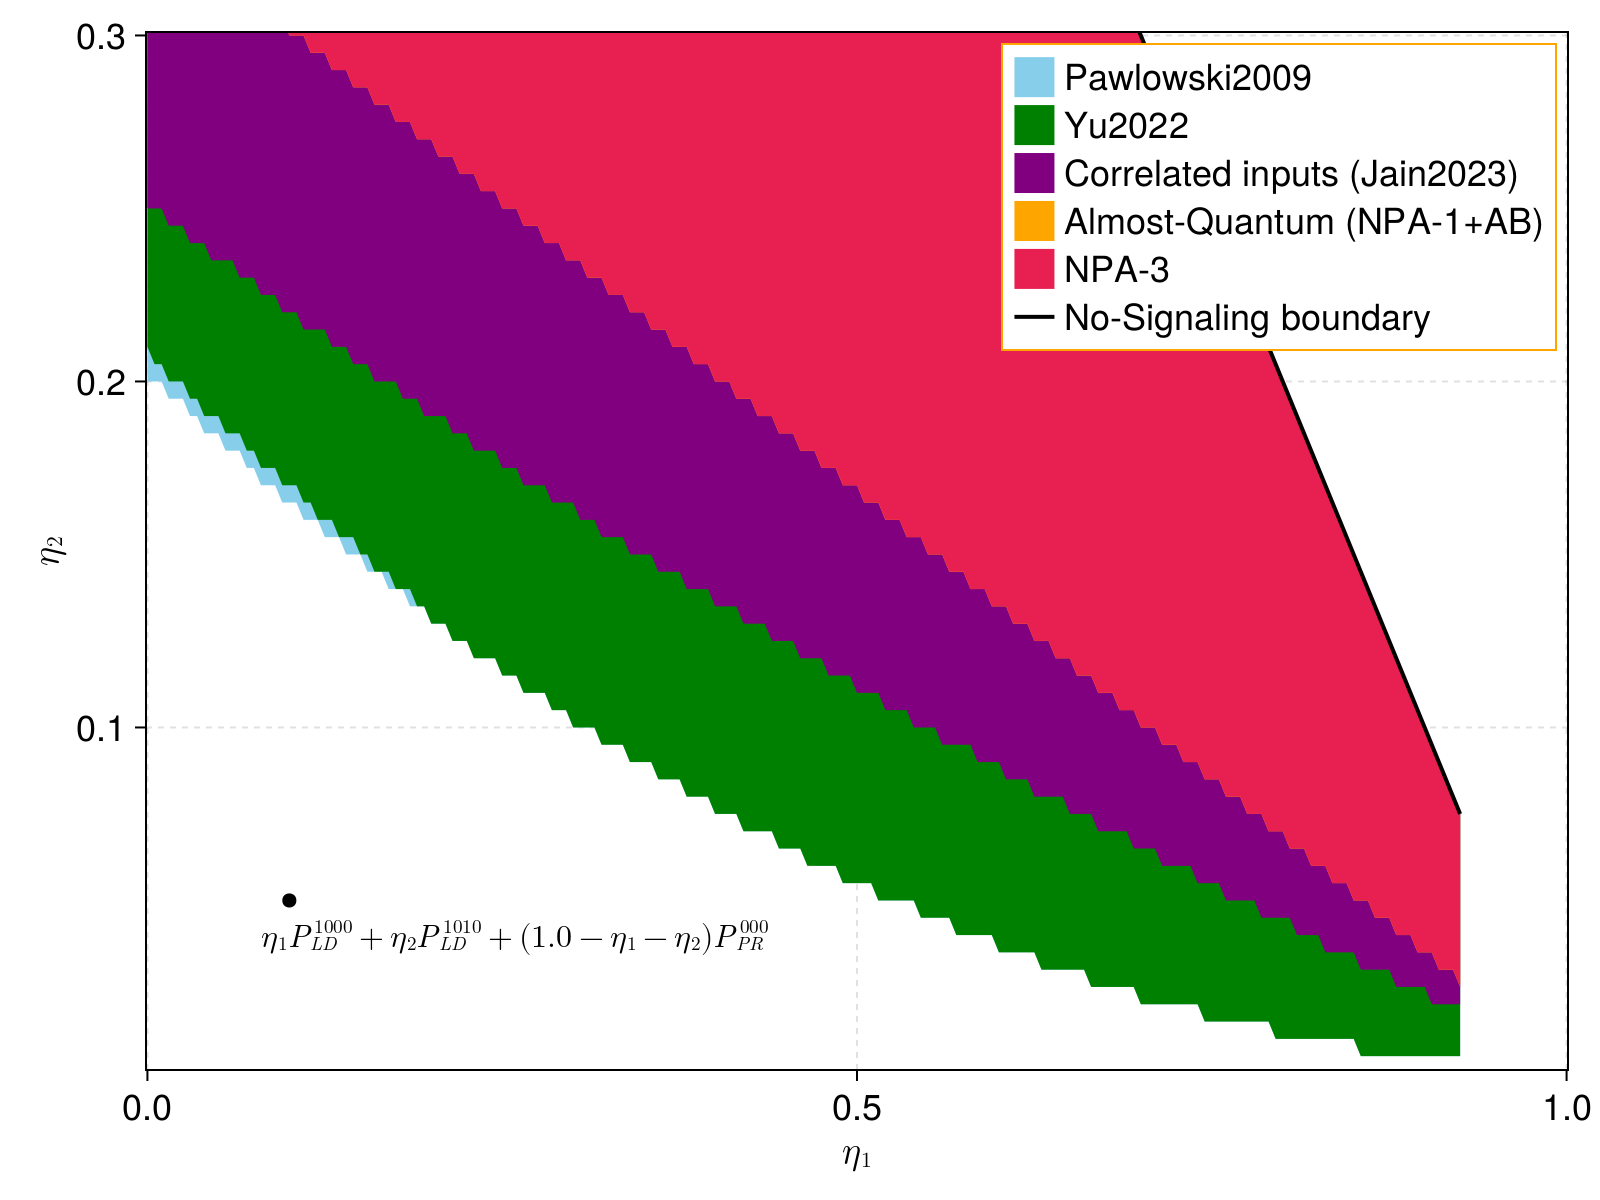

In [26]:

eval_conditions = Dict("NPA-3" => "quantum_", 
                        "Pawlowski2009" => "IC_",
                        "Yu2022" => "Redundant_IC_",
                        "Correlated inputs (Jain2023)" => "CorrelatedInputs_IC_",
                        #"Almost-Quantum (NPA-1+AB)" => "AlmostQuantum_"
                        )

cmap = [:skyblue, :green, :purple, "#e82051", ]

cutoff = 13

with_theme(palette = (; patchcolor = cgrad(cmap, alpha=1.0))) do

    fig = Figure(; size = (800,600), fontsize = 18)
    ax = Axis(fig[1, 1]; title = " ", xgridstyle = :dash, ygridstyle = :dash, xlabel = L"\eta_1", ylabel = L"\eta_2")
        
    for condition_key in ["Pawlowski2009", "Yu2022", "Correlated inputs (Jain2023)",  "NPA-3"]
        q1_vals, q2_vals = data_output[eval_conditions[condition_key]*"q1_vals"], data_output[eval_conditions[condition_key]*"q2_vals"]
        #lines!(q1_vals, q2_vals; label = condition_key) #, color = :green
        
        q1_vals = q1_vals[1:end-cutoff]
        q2_vals = q2_vals[1:end-cutoff]

        band!(q1_vals, q2_vals, 1 .- q1_vals; label = condition_key)
        if condition_key == "NPA-3"
            lines!(q1_vals, 1 .- q1_vals; label = "No-Signaling boundary", color = :black, linewidth = 2)
        end
    end
    
    scatter!([0.1], [0.05], color = :black, markersize = 10)
    text!(L"\eta_1 P_{LD}^{\, 1000} + \eta_2 P_{LD}^{\, 1010} + (1.0-\eta_1-\eta_2) P_{PR}^{\, 000}"; position=(0.08, 0.05-0.005), space = :data, align = (:left, :top), color = :black, fontsize = 16)

    #translate!(lineplot, 0, 0, 2) # move line to foreground
    limits!(-0.001, 1.001, 0.001, 0.301)
    axislegend(; position = :rt, framecolor = :orange)
    #save(plotsdir("NSSliceBounds", "eta1eta2_space_extended_bounds_with_NSBoundary.png"), fig)
    fig
end